# DATASCI W261: Machine Learning at Scale

# Group 3 - HW13.4,13.5 - Criteo at Scale

### Useful References and Notebook Setup:
- **[Original Assignment Instructions](https://www.dropbox.com/s/gsti4plbst7ena3/MIDS-MLS-HW-13.txt?dl=0)**


In [ ]:
%matplotlib inline

In [ ]:
#Only needed to start Spark locally, unnecessary in AWS 
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = \
   '/Users/nicholashamlin/spark-1.6.1-bin-hadoop2.6/'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
 

## HW 13.4: Criteo Phase 2 baseline

### Problem Statement:

SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please use them and build on them.

The Criteo data for this challenge is located in the following S3/Dropbox buckets:

On Dropbox see:
     https://www.dropbox.com/sh/dnevke9vsk6yj3p/AABoP-Kv2SRxuK8j3TtJsSv5a?dl=0

Raw Data:  (Training, Validation and Test data)
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=rawdata/

Hashed Data: Training, Validation and Test data in hash encoded (10,000 buckets) and sparse representation
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=processeddata/


Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:

-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparamters:

-- Number of buckets for hashing: 1,000
-- Logistic Regression: no regularization term
-- Logistic Regression: step size = 10

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

Dont forget to put a caption on your tables (above each table).

### Import packages and setup raw data in Spark

In [16]:
%matplotlib inline

In [42]:
#Load required dependencies
import os
import time
from math import log,exp
from collections import OrderedDict,defaultdict
from itertools import product
import hashlib

import numpy as np
import pylab as plt

from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics

### Load data - LOCAL VERSION
This is just to test our spark setup and run things locally before graduating to AWS

In [43]:
#Load Raw Data - LOCAL VERSION
fileName='dac_sample.txt'
if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 2)
               .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
rawData.count()

100000

In [45]:
#SPLIT DATA INTO TRAIN/VALIDATION/TEST - LOCAL TESTING
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print "NUMBER OF RECORDS"
print "Training: {0}".format(nTrain)
print "Validation: {0}".format(nVal)
print "Test: {0}".format(nTest)
print "Total: {0}".format(nTrain + nVal + nTest)


NUMBER OF RECORDS
Training: 79911
Validation: 10075
Test: 10014
Total: 100000


### Load data - FULL VERSION
Having confirmed things work locally, now we run the same sample data in EMR

In [2]:
#Load Raw Data - EMR VERSION WITH SAMPLE DATA
fileName="s3://hamlin-mids-261/dac_sample.txt"
rawData = (sc.textFile(fileName, 2).map(lambda x: x.replace('\t', ',')))
#rawData.cache()
rawData.count()

100000

In [3]:
#Load ONE file first
testFile="s3://criteo-dataset/rawdata/test/part-00000"
rawTestData = (sc.textFile(testFile, 2).map(lambda x: x.replace('\t', ',')))
nTest = rawTestData.count()
print "Test: {0}".format(nTest)

Test: 27807


In [4]:
#Location of full dataset in S3
trainFile="s3://criteo-dataset/rawdata/train/part-*"
validationFile="s3://criteo-dataset/rawdata/validation/part-*"
testFile="s3://criteo-dataset/rawdata/test/part-*"

In [6]:
#Load Everything!
rawTrainData = (sc.textFile(trainFile, 2).map(lambda x: x.replace('\t', ','))).cache()
rawValidationData = (sc.textFile(validationFile, 2).map(lambda x: x.replace('\t', ','))).cache()
rawTestData = (sc.textFile(testFile, 2).map(lambda x: x.replace('\t', ','))).cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print "NUMBER OF RECORDS"
print "Training: {0}".format(nTrain)
print "Validation: {0}".format(nVal)
print "Test: {0}".format(nTest)
print "Total: {0}".format(nTrain + nVal + nTest)


NUMBER OF RECORDS
Training: 36669090
Validation: 4585184
Test: 4586343
Total: 45840617


### Define functions to evaluate models
(These are recycled from HW 12)

In [46]:
def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if y==1:
        return -log(p+epsilon)
    elif y==0:
        return -log(1-p+epsilon)

In [47]:
def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction=x.dot(w)+intercept
    

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    output = (1+exp(-rawPrediction))**-1
    return output

In [48]:
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    output=data.map(lambda x: computeLogLoss(getP(x.features,model.weights,model.intercept), x.label)).sum()/data.count()
    return output

In [49]:
#Define Hash Function

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

In [50]:
#Use Hash function to create labeled points with hashed features

def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    output=[]
    features=point.split(',')
    label=features[0]
    for i,j in enumerate(features[1:]):
        output.append((i,j))
    output.sort()
    hashResult=hashFunction(numBuckets,output)
    sortedHashResult=OrderedDict(sorted(hashResult.items(), key=lambda t: t[0]))
    sparse=SparseVector(numBuckets,sortedHashResult.keys(),sortedHashResult.values())
    return LabeledPoint(label,sparse)


### Generate Features and Train Baseline Model

- Number of buckets for hashing: 1,000
- Logistic Regression: no regularization term
- Logistic Regression: step size = 10

In [18]:
#Baseline model parameters
stepSize=10 #GD stepsize
regType=None #Regularization
numBucketsCTR = 1000 #Number of buckets into which we want to hash features

#Hash all three datasets
start_hash_time=time.time()
hashTrainData = rawTrainData.map(lambda point: parseHashPoint(point,numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda point: parseHashPoint(point,numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda point: parseHashPoint(point,numBucketsCTR))
hashTestData.cache()

start_train_time = time.time()
#train(data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.01, regType='l2', intercept=False, validateData=True, convergenceTol=0.001)[source]
model = LogisticRegressionWithSGD.train(hashTrainData, step=stepSize, regType=regType, intercept=True)

end_time=time.time()
print "Feature hashing for all data took {0} seconds".format(start_train_time-start_hash_time)
print "Model trained in {0} seconds".format(end_time-start_train_time)


Feature hashing for all data took 0.0308191776276 seconds
Model trained in 1915.60110497 seconds


In [19]:
model.save(sc, 's3://hamlin-mids-261/hw13_baseline')

### Evaluate results

In [20]:
#Calculate baseline AUC on full dataset
trainResults = hashTrainData.map(lambda lp: (float(model.predict(lp.features)), lp.label))
validationResults = hashValidationData.map(lambda lp: (float(model.predict(lp.features)), lp.label))
testResults = hashTestData.map(lambda lp: (float(model.predict(lp.features)), lp.label))

trainMetrics = BinaryClassificationMetrics(trainResults)
validationMetrics = BinaryClassificationMetrics(validationResults)
testMetrics = BinaryClassificationMetrics(testResults)

print "AUC RESULTS"
print "Training: {0}".format(trainMetrics.areaUnderROC)
print "Validation: {0}".format(validationMetrics.areaUnderROC)
print "Test: {0}".format(testMetrics.areaUnderROC)

AUC RESULTS
Training: 0.582128506212
Validation: 0.582249919283
Test: 0.582221271582


In [21]:
#Calculate LogLoss Results on full dataset
logLossTrain = evaluateResults(model, hashTrainData)
logLossVal = evaluateResults(model, hashValidationData)
logLossTest = evaluateResults(model, hashTestData)
print "LOGLOSS RESULTS"
print "Training: {0}".format(logLossTrain)
print "Validation: {0}".format(logLossVal)
print "Test: {0}".format(logLossTest)

LOGLOSS RESULTS
Training: 0.505463996931
Validation: 0.505676112056
Test: 0.505602800332


In total, these results took 1924 seconds to run on a 6 node r3.xlarge cluster.

## HW 13.5: Criteo Phase 2 hyperparameter tuning

### Problem Statement
 
Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

Discuss the optimal setting to solve this problem  in terms of the following:
-- Features
-- Learning algortihm
-- Spark cluster

Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.

### Setup infrastructure for gridsearch strategy

In [2]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

/usr/local/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime


In [33]:
regType = 'l2'
includeIntercept = True
results = []

numBuckets = [1000, 5000, 10000]
numIters =   [100,500]
stepSizes =  [10, 15, 18, 20, 30]
regParams =  [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

time: 11.2 ms


In [34]:
runId = 1
for numBucket in numBuckets:
    
    start_train_time = time.time()
    hashTrainData      = rawTrainData.map(lambda point: parseHashPoint(point, numBucket))
    hashValidationData = rawValidationData.map(lambda point: parseHashPoint(point, numBucket))
    hashTestData       = rawTestData.map(lambda point: parseHashPoint(point, numBucket))

    hashTrainData.count()
    hashValidationData.count()
    hashTestData.count() 

    hashTrainData.cache()
    hashValidationData.cache()
    hashTestData.cache() 
    
    end_time = time.time()
    buckettimesec = end_time - start_train_time
    
    for numIter in numIters:
        for stepSize in stepSizes:
            for regParam in regParams:
                
                print "Run Id : {0}, numBucket = {1}, numIter={2}, stepSize = {3}, regParam = {4}".format(runId, numBucket, numIter, stepSize, regParam)
                
                start_train_time = time.time()
                model = LogisticRegressionWithSGD.train(hashTrainData, iterations=numIter, step=stepSize, regParam=regParam, 
                                                       regType=regType,intercept=includeIntercept)
                end_time = time.time()
                traintimesec = end_time - start_train_time
                
                # -----------------------------------------------------------
                trainResults = hashTrainData.map(lambda lp: (float(model.predict(lp.features)), lp.label))
                validationResults = hashValidationData.map(lambda lp: (float(model.predict(lp.features)), lp.label))
                testResults = hashTestData.map(lambda lp: (float(model.predict(lp.features)), lp.label))

                trainMetrics = BinaryClassificationMetrics(trainResults)
                validationMetrics = BinaryClassificationMetrics(validationResults)
                testMetrics = BinaryClassificationMetrics(testResults)

                trainROC = trainMetrics.areaUnderROC
                valROC = validationMetrics.areaUnderROC
                testROC = testMetrics.areaUnderROC
                
                logLossTrain = evaluateResults(model, hashTrainData)
                logLossVal = evaluateResults(model, hashValidationData)
                logLossTest = evaluateResults(model, hashTestData)

                results.append( [runId, buckettimesec, traintimesec, numBucket, numIter, stepSize, regParam, trainROC, valROC, testROC, logLossTrain, logLossVal, logLossTest])
                print "buckettimesec = {0}, traintimesec = {1}, trainROC = {2}, valROC = {3}, testROC = {4}, logLossTrain = {5}, logLossVal = {6}, logLossTest = {7}".format(buckettimesec, traintimesec,  trainROC, valROC, testROC, logLossTrain, logLossVal, logLossTest)
                runId += 1 

#Pickle results so we can analyze later offline
import pickle
with open("results.pk", 'wb') as f:
    pickle.dump(results, f)

Run Id : 1, numBucket = 1000, numIter=100, stepSize = 10, regParam = 1e-06
buckettimesec = 480.182461977, traintimesec = 545.590419054, trainROC = 0.582129416374, valROC = 0.582248614076, testROC = 0.582221550021, logLossTrain = 0.505464359462, logLossVal = 0.505676478333, logLossTest = 0.505603161929
Run Id : 2, numBucket = 1000, numIter=100, stepSize = 10, regParam = 1e-05
buckettimesec = 480.182461977, traintimesec = 96.8530468941, trainROC = 0.582141722927, valROC = 0.582265251651, testROC = 0.582235984399, logLossTrain = 0.505468270009, logLossVal = 0.50568044047, logLossTest = 0.505607068285
Run Id : 3, numBucket = 1000, numIter=100, stepSize = 10, regParam = 0.0001
buckettimesec = 480.182461977, traintimesec = 95.4933099747, trainROC = 0.582029591023, valROC = 0.582152642396, testROC = 0.58212123502, logLossTrain = 0.505493094293, logLossVal = 0.505705375566, logLossTest = 0.505631720645
Run Id : 4, numBucket = 1000, numIter=100, stepSize = 10, regParam = 0.001
buckettimesec = 4

### Tabular Gridsearch Results

In [12]:
#Load our pickled data so 
with open('results.pk','r') as f:
    results=pickle.load(f)

In [4]:
#Generate AUC Table
print "TABLE 1: GRIDSEARCH AUC RESULTS (best results shown with **)"
print ""
print "ID  | Buckets| Iter. | Step | Reg. Param | Train Time | Train AUC | Val AUC | Test AUC"
print '-'*85
for i in results:
    if i[9]>0.63: #Highlight Interesting Values
        print '{8:>3} |  {0:>5} |  {1}  |  {2}  | {3:.6f}   |  {4:>6.2f}    |  {5:>.5f}  | {6:>.5f} | {6:>.5f}**'.format(i[3],i[4],i[5],i[6],i[2],i[7],i[8],i[9],i[0])
    else:
        print '{8:>3} |  {0:>5} |  {1}  |  {2}  | {3:.6f}   |  {4:>6.2f}    |  {5:>.5f}  | {6:>.5f} | {6:>.5f}'.format(i[3],i[4],i[5],i[6],i[2],i[7],i[8],i[9],i[0])


TABLE 1: GRIDSEARCH AUC RESULTS (best results shown with **)

ID  | Buckets| Iter. | Step | Reg. Param | Train Time | Train AUC | Val AUC | Test AUC
-------------------------------------------------------------------------------------
  1 |   1000 |  100  |  10  | 0.000001   |  545.59    |  0.58213  | 0.58225 | 0.58225
  2 |   1000 |  100  |  10  | 0.000010   |   96.85    |  0.58214  | 0.58227 | 0.58227
  3 |   1000 |  100  |  10  | 0.000100   |   95.49    |  0.58203  | 0.58215 | 0.58215
  4 |   1000 |  100  |  10  | 0.001000   |   98.00    |  0.57894  | 0.57903 | 0.57903
  5 |   1000 |  100  |  10  | 0.010000   |   96.37    |  0.55448  | 0.55458 | 0.55458
  6 |   1000 |  100  |  15  | 0.000001   |   95.14    |  0.52775  | 0.52802 | 0.52802
  7 |   1000 |  100  |  15  | 0.000010   |   95.12    |  0.52662  | 0.52689 | 0.52689
  8 |   1000 |  100  |  15  | 0.000100   |   95.13    |  0.65980  | 0.65959 | 0.65959**
  9 |   1000 |  100  |  15  | 0.001000   |   94.12    |  0.52131  | 0.52149

In [5]:
#Generate LogLoss Table
print "TABLE 2: GRIDSEARCH LOGLOSS RESULTS (best results shown with **)"
print ""
print "ID  | Buckets| Iter. | Step | Reg. Param | Train Time |  Train LL |  Val LL | Test LL"
print '-'*85
for i in results:
    if i[10]<0.49: #Highlight interesting rows
        print '{8:>3} |  {0:>5} |  {1}  |  {2}  | {3:.6f}   |  {4:>6.2f}    |  {5:>.5f}  | {6:>.5f} | {6:>.5f}**'.format(i[3],i[4],i[5],i[6],i[2],i[10],i[11],i[12],i[0])
    else:
        print '{8:>3} |  {0:>5} |  {1}  |  {2}  | {3:.6f}   |  {4:>6.2f}    |  {5:>.5f}  | {6:>.5f} | {6:>.5f}'.format(i[3],i[4],i[5],i[6],i[2],i[10],i[11],i[12],i[0])


TABLE 2: GRIDSEARCH LOGLOSS RESULTS (best results shown with **)

ID  | Buckets| Iter. | Step | Reg. Param | Train Time |  Train LL |  Val LL | Test LL
-------------------------------------------------------------------------------------
  1 |   1000 |  100  |  10  | 0.000001   |  545.59    |  0.50546  | 0.50568 | 0.50568
  2 |   1000 |  100  |  10  | 0.000010   |   96.85    |  0.50547  | 0.50568 | 0.50568
  3 |   1000 |  100  |  10  | 0.000100   |   95.49    |  0.50549  | 0.50571 | 0.50571
  4 |   1000 |  100  |  10  | 0.001000   |   98.00    |  0.50573  | 0.50594 | 0.50594
  5 |   1000 |  100  |  10  | 0.010000   |   96.37    |  0.51068  | 0.51087 | 0.51087
  6 |   1000 |  100  |  15  | 0.000001   |   95.14    |  0.61581  | 0.61625 | 0.61625
  7 |   1000 |  100  |  15  | 0.000010   |   95.12    |  0.61779  | 0.61823 | 0.61823
  8 |   1000 |  100  |  15  | 0.000100   |   95.13    |  0.57097  | 0.57107 | 0.57107
  9 |   1000 |  100  |  15  | 0.001000   |   94.12    |  0.62936  | 0.6298

Based on the results above, we see that the combination of 5000 buckets and 100 iterations produces some of the best results for test AUC and logloss while still maintaining a relatively reasonable runtime.  With that in mind, we'll drill down into the specific combinations of step size and regularization parameters.

### Heatmaps of Gridsearch Results

In [27]:
#Recap Hyperparameter space so we can reference it below
regType = 'l2'
includeIntercept = True
numBuckets = [1000, 5000, 10000]
numIters =   [100,500]
stepSizes =  [10, 15, 18, 20, 30]
regParams =  [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

In [39]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    #plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#000000', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#000000')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [47]:
#Define a list of fields in our results to make lookups easier
fields=['idnum','hashTime','trainTime','numBuckets','numIters',
        'stepSizes','regParams','trainAUC','valAUC','testAUC',
        'trainLL','valLL','testLL']

def heatmap(c1,c2,c1val,c2val,v1,v2,field_to_plot,xlab,ylab,title):
    """
    Plot a heatmap of a given subset of our overall hyperparameter space
    """
    
    #Munge data into the right format for heatmapping
    values=[i[fields.index(field_to_plot)]for i in results if (i[fields.index(c1)]==c1val and i[fields.index(c2)]== c2val)]
    value_array = np.array([values])
    numRows, numCols = len(v2), len(v1)
    value_array = np.array(value_array)
    value_array.shape = (numRows, numCols)

    #Set up plot itself
    fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(6, 6),
                          hideLabels=False, gridWidth=0.)
    ax.set_xticklabels(v1), ax.set_yticklabels(v2)
    ax.set_xlabel(xlab), ax.set_ylabel(ylab)
    ax.set_title(title)
    image = plt.imshow(value_array,interpolation='nearest', aspect='auto',cmap = 'Greens')

    #Add value labels
    label_colors=np.where(values > np.percentile(values, 75), "white", "black") #Invert labels for good contrast
    label_counter=0
    for y in range(numRows):
        for x in range(numCols):
            plt.text(x, y, '%.4f' % value_array[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                    color=label_colors[label_counter])
            label_counter+=1
            

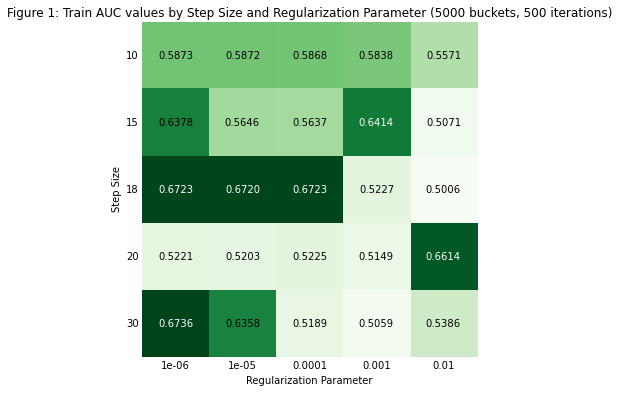

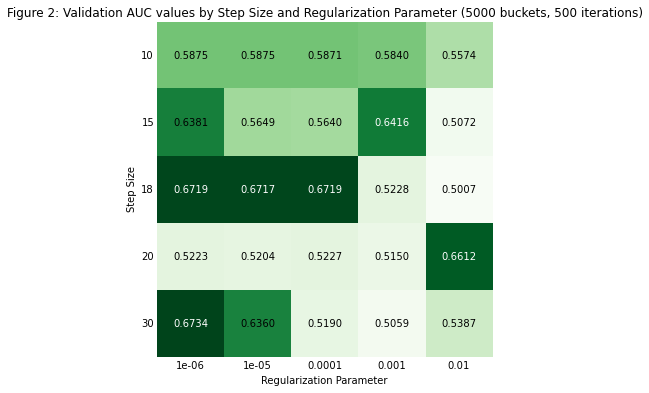

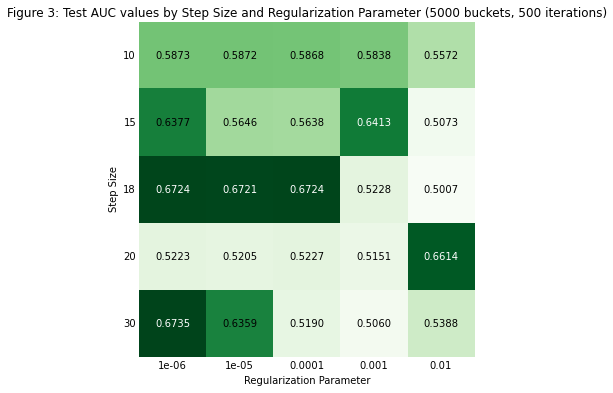

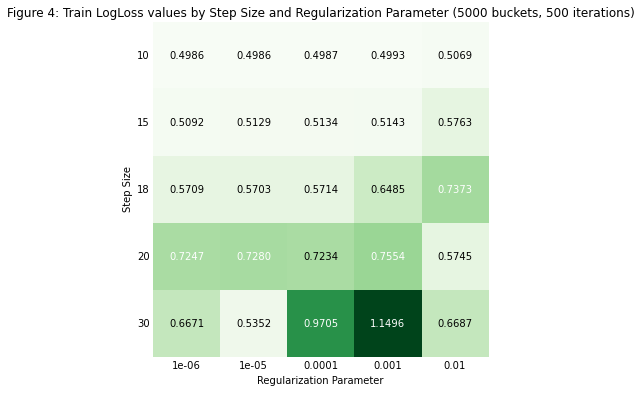

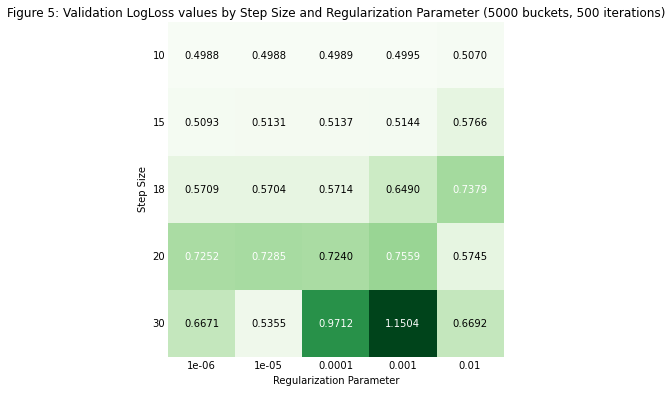

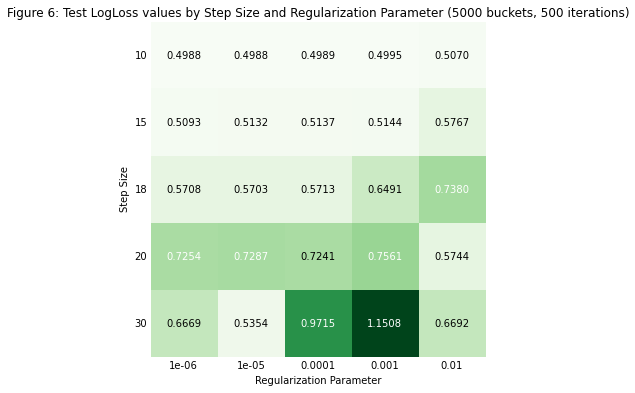

In [49]:
#Plot all train/validation/test AUC/LogLoss results for 5000 buckets/500 iterations
f1="Figure 1: Train AUC values by Step Size and Regularization Parameter (5000 buckets, 500 iterations)"
heatmap('numBuckets','numIters',5000,100,regParams,stepSizes,'trainAUC','Regularization Parameter','Step Size',f1)

f2="Figure 2: Validation AUC values by Step Size and Regularization Parameter (5000 buckets, 500 iterations)"
heatmap('numBuckets','numIters',5000,100,regParams,stepSizes,'valAUC','Regularization Parameter','Step Size',f2)

f3="Figure 3: Test AUC values by Step Size and Regularization Parameter (5000 buckets, 500 iterations)"
heatmap('numBuckets','numIters',5000,100,regParams,stepSizes,'testAUC','Regularization Parameter','Step Size',f3)

f4="Figure 4: Train LogLoss values by Step Size and Regularization Parameter (5000 buckets, 500 iterations)"
heatmap('numBuckets','numIters',5000,100,regParams,stepSizes,'trainLL','Regularization Parameter','Step Size',f4)

f5="Figure 5: Validation LogLoss values by Step Size and Regularization Parameter (5000 buckets, 500 iterations)"
heatmap('numBuckets','numIters',5000,100,regParams,stepSizes,'valLL','Regularization Parameter','Step Size',f5)

f6="Figure 6: Test LogLoss values by Step Size and Regularization Parameter (5000 buckets, 500 iterations)"
heatmap('numBuckets','numIters',5000,100,regParams,stepSizes,'testLL','Regularization Parameter','Step Size',f6)

### Discussion of Results

Based on the heatmaps, it's pretty clear that our optimal results lie in the bottom left corner, which contains the largest AUC values and smallest logloss results across the hyperparameter space.  Referencing these back to the tables shown above, a configuration like option 72 in Tables 1 and 2 (5000 buckets, 100 iterations, step size of 30, regularization parameter of 0.000010) produces one of our best results across both success criteria

These results were generated by a 6 node cluster of r3.2xlarge machines (scaled up from what we used on the baseline) running logistic regression with L2 Regularization.  Interestingly, the entire gridsearch process took longer than expected (Approx. 19 hours) to complete the full search of the hyperparameter space, despite using 2 executors with 12 GB of memory each.  There are a few reasons why we might be seeing this kind of performance.  First, we're iterating of quite a large number of combinations (250 total).  Next, we're also running each combination of hyperparameters for, at a minimum, 100 iterations (500 iterations in some cases).  Even though we're able to cache our data in Spark to expedite this process, we might see better performance by reducing the nubmer of iterations we run for each combination.  Lastly, we may also be able to improve runtime by further optimizing the partitioning of our data, configuration of our cluster, and strategic use of memory on the large dataset.